# Assignment 1: Data Analysis & Visualization
___________

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Imports

Execute the cell below to import all packages you will be using in the rest of the assignemnt.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

## Description of the dataset

This assignment is based on the 20 Newsgroups Dataset. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

There are three versions of the 20 Newsgroups Dataset. In this assignment we will use the `bydate` matlab version in which documents are sorted by date into training (60%) and test (40%) sets, newsgroup-identifying headers are dropped and duplicates are removed. This collection comprises roughly 61,000 different words, which results in a bag-of-words representation with frequency counts. More specifically, each document is represented by a 61,000 dimensional vector that contains the counts for each of the 61,000 different words present in the respective document. 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related. Additionally, we computed the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) of each word with the class attribute and selected the 520 words out of 61,000 that had highest mutual information. Therefore, our dataset is a $N \times 520$ dimensional matrix, where $N$ is the number of documents. For very sophisticated technical reasons 1 was added to all the word counts in part A. The resulting representation is much more compact and can be used directly to perform our experiments in Python.

## 1. Exploration of the dataset [40%]

### ========== Question 1.1 --- [5 marks] ==========
Load the datasets `train_20news_partA.csv` and `train_20news_partB.csv` into two separate pandas DataFrames.

In [6]:
data_path_A = os.path.join(os.getcwd(), 'data', 'train_20news_partA.csv')
data_path_B = os.path.join(os.getcwd(), 'data', 'train_20news_partB.csv')
news_A = pd.read_csv(data_path_A, delimiter = ',')
news_B = pd.read_csv(data_path_B, delimiter = ',')

### ========== Question 1.2 --- [3 marks] ==========
Display basic information for dataset A such as number of columns, type, and memory usage (*hint: pandas dataframes have a built in method for this*) 

In [7]:
news_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129 entries, 0 to 2256
Columns: 521 entries, w1_aaa to class
dtypes: int64(521)
memory usage: 8.5 MB


### ========== Question 1.3 --- [3 marks] ==========
How many data points and how many attributes are there in the dataset that we can use to model the target variable `class`?

There are 2129 data points and 520 attributes. 
* Data points correspond to the examples of classified documents (rows in the training database).
* Attributes (here) represent how often pruned vocabulary words occured in the document (a vocabulary-sized feature vector of word occurance counts for every data point). 

In our case, the vocabulary consists of 520 words with highest mutual information among classes (document types), thus, each row (data point) is described in terms of a 520 dimensional vector (+extra 1 for class decision), and the news_A dataset is then a $2129 \times 521$ dimensional matrix.

### ========== Question 1.4 --- [3 marks] ==========
Use a Pandas method to display the summary statistics for the `news_A` DataFrame.

In [8]:
news_A.describe()

,w1_aaa,w2_pins,w3_kmr,w4_notion,w5_queens,w6_dwyer,w7_defenseman,w8_gld,w9_tocchet,w10_home,...,w512_constantly,w513_generate,w514_definite,w515_lacks,w516_combination,w517_sitting,w518_surface,w519_fashion,w520_sit,class
count,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000,2129.00000,2129.000000,2129.000000,2129.000000,2129.000000,...,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000
mean,5.128229,6.097698,6.120244,5.551902,5.521841,6.12776,5.633161,6.090653,5.970409,5.624706,...,9.666510,9.217473,9.061531,9.398309,9.175200,9.708783,8.807891,9.719587,9.307656,3.092532
std,38.292577,46.190953,46.656022,40.953913,40.978098,45.96434,41.146918,45.762060,44.266628,40.769105,...,45.844064,43.948910,40.969185,43.833064,42.403283,47.294120,39.341038,46.185082,45.059367,1.395948
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,3.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,4.000000
max,572.000000,583.000000,579.000000,580.000000,591.000000,600.00000,546.000000,591.000000,578.000000,578.000000,...,590.000000,587.000000,577.000000,598.000000,568.000000,599.000000,585.000000,600.000000,597.000000,5.000000


### ========== Question 1.5 --- [3 marks] ==========
Display the first 7 instances of dataset A.

In [9]:
news_A.head(7)

,w1_aaa,w2_pins,w3_kmr,w4_notion,w5_queens,w6_dwyer,w7_defenseman,w8_gld,w9_tocchet,w10_home,...,w512_constantly,w513_generate,w514_definite,w515_lacks,w516_combination,w517_sitting,w518_surface,w519_fashion,w520_sit,class
0,1,1,1,1,1,1,1,1,1,1,...,1,5,3,6,8,4,6,4,8,4
1,1,1,1,1,1,1,1,1,1,1,...,2,3,6,8,3,4,5,6,5,4
2,1,1,1,1,1,1,1,1,1,2,...,4,2,6,5,2,5,5,7,8,2
3,1,1,1,1,1,1,1,1,1,1,...,6,3,6,1,1,8,1,8,4,3
4,1,1,1,1,1,1,1,1,1,1,...,6,1,7,8,6,3,1,8,4,3
5,1,1,1,1,1,1,1,1,1,1,...,7,5,4,5,5,7,7,7,2,2
6,1,1,1,1,2,1,1,1,1,1,...,3,6,8,8,3,5,2,1,2,1


### ========== Question 1.6 --- [5 marks] ==========
Display the names of the first 100 attributes in dataset A. 

You might observe that each attribute consists of two parts:
1. `w<x>_` (where x is an index corresponding to each word)
2. the actual name of the word

In [10]:
def clean(input_string): 
    return (''.join ([ch for ch in input_string if ch.isalpha()]))

names = ([clean(entry)[1:] for entry in news_A.columns.values[:100]])
for number, name in enumerate(names): 
    print (number+1, name)

1 aaa
2 pins
3 kmr
4 notion
5 queens
6 dwyer
7 defenseman
8 gld
9 tocchet
10 home
11 buying
12 internet
13 slots
14 compatible
15 transfer
16 baltimore
17 mean
18 person
19 performance
20 support
21 tor
22 gm
23 mouse
24 base
25 population
26 bob
27 set
28 it
29 earth
30 faith
31 steve
32 caps
33 printer
34 east
35 cable
36 adapter
37 mss
38 catcher
39 bullpen
40 obp
41 innocent
42 european
43 angeles
44 settings
45 words
46 rit
47 shots
48 ports
49 vga
50 coverage
51 jumpers
52 bases
53 sea
54 pts
55 behavior
56 domi
57 sabres
58 yzerman
59 messier
60 goalies
61 hawks
62 our
63 sx
64 view
65 hitters
66 richard
67 point
68 nyi
69 mvp
70 kill
71 nl
72 field
73 connector
74 stars
75 th
76 install
77 traded
78 configuration
79 standard
80 rotation
81 ultb
82 sports
83 pds
84 canada
85 did
86 clock
87 first
88 switch
89 tonight
90 record
91 singer
92 majors
93 royals
94 does
95 flames
96 of
97 series
98 plays
99 det
100 pitched


### ========== Question 1.7 --- [4 marks] ==========
Familiarise yourself with the [`stripplot`](https://seaborn.github.io/generated/seaborn.stripplot.html?highlight=stripplot#seaborn.stripplot) function in `seaborn`. Pick one attribute of your choice (except `class`) and display a stripplot for that attribute for dataset A. Demonstrate the distribution of the data separately for each class (by making appropriate use of the `x` argument in `stripplot`). Set the `jitter` argument to `True` and the `alpha` argument to an appropriate value (to add transparency). When the jitter parameter is enabled a small amount of noise is added to the data so that there is less overlap and the distribution is easier to visualise.

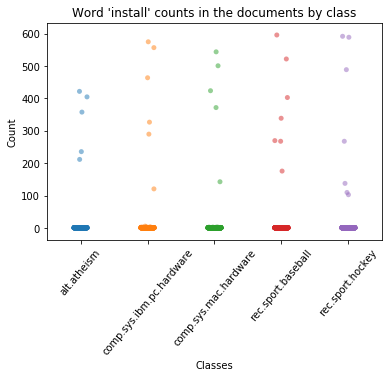

In [16]:
fig = sns.stripplot(x="class", y="w76_install", data = news_A, jitter=True, alpha = 0.5)
labels = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.sport.baseball', 'rec.sport.hockey']
fig.set_xticklabels(labels, minor=False, rotation=50)
fig.set_title("Word 'install' counts in the documents by class")
fig.set_ylabel("Count")
fig.set_xlabel("Classes")
print()

### ========== Question 1.8 --- [4 marks] ==========
The stripplot illustrates the distribution of a single attribute. We can also visualise the joint distribution of two variables by using a scatter plot. Again, we want to add a bit of noise into the data so that is easier to see which parts of the space (2-dimensional in our case) have larger probability densities. 

For this, you will be using the function `scatter_jitter` provided below. This function takes as input two numpy arrays containing the features of interest. Pick two attributes of your choice from dataset A and use the provided function to plot their joint distribution. You can play around with the amount of noise added by tweaking the `jitter` parameter. Alternatively, you can just use its default value which is set to 0.2.

In [34]:
def scatter_jitter(arr1, arr2, jitter=0.2):
    """ Plots a joint scatter plot of two arrays by adding small noise to each example. 
    Noise is proportional to variance in each dimension. """
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    arr1 = arr1 + jitter*arr1.std(axis=0)*np.random.standard_normal(arr1.shape)
    arr2 = arr2 + jitter*arr2.std(axis=0)*np.random.standard_normal(arr2.shape)
    plt.scatter(arr1, arr2, marker=5, c='g')

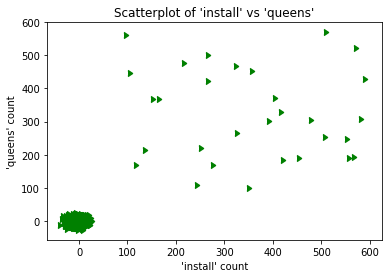

In [35]:
scatter_jitter(news_A["w76_install"], news_A["w5_queens"])
plt.xlabel("'install' count")
plt.ylabel("'queens' count")
plt.title("Scatterplot of 'install' vs 'queens'")
print()

### ========== Question 1.9 --- [7 marks] ==========
From the strip and scatter plots above you might observe that there is something peculiar about the data. Indeed most attributes take very small values (usually in the range 1-10) but there are some data points (i.e. rows) in the dataset where the attributes take very large values. These data points are called [outliers](https://en.wikipedia.org/wiki/Outlier).

You might think that the presence of outliers in the dataset has been a resut of noise contamination (you wouldn't expect the same word to appear 600 times within an e-mail, would you?). Your job now is to create a new dataset from dataset A (name it `news_A_clean`) and remove the outliers. Create some metric to find the outliers and check that your metric is reasonable. Be careful not to alter the original `news_A`...we may require it in its dirty format later...

In [ ]:
# Your CODE GOES HERE

### ========== Question 1.10 --- [3 marks] ==========
Write code to return the number of data points in the clean dataset, and the number of documents that have been excluded as outliers

In [ ]:
# Your CODE GOES HERE

## 2. Naive Bayes classification [60%]
Now we want to fit a Gaussian Naive Bayes model to the cleaned dataset A. You might want first to familiarise yourself with the [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) class in `Sklearn`.

### ========== Question 2.1 --- [4 marks] ==========

By using the `scatter_jitter` function provided above, display a scatter plot of the features `w281_ico` and `w273_tek` for the cleaned dataset A. Set the jitter value to something small (e.g. 0.1). Label axes appropriately.

In [ ]:
# Your CODE GOES HERE

### ========== Question 2.2 --- [6 marks] ==========
What do you observe? 

How does that relate to the Naive Bayes assumption? 

What would be the main issue we would have to face if we didn't make this assumption?

It can be observed that the 'ico' and 'tek' count distributions somewhat covary (similar amount of both words occur within the documents accross all dataset, rarely one of the words occur separately or more often than another), implying that the words themselves might be conditionally dependent on each other. 
In fact, words can often prime each other's appearance, e.g., "brown dog" vs. "brown banana". 

Naive Bayes makes an independence assumption between every pair of features (words, in this case), as well as between their positions in the sentence/text, which is necessary in order to simplify the problem and make it managable in practice. Not doing so would result in an enormous computational overhead, as well as very sparse data (Zipf's law + sequences of words). 

Despite this over-simplification, Naive Bayes classifiers work well in many real-world situations (e.g., document classification, spam filtering), and are very efficient (require a small amount of data to estimate parameters). 

### ========== Question 2.3 --- [5 marks] ==========
Fit a Gaussian Naive Bayes model to the cleaned dataset A. Your input features should be all the attributes in the dataset except the `class` attribute which will be your target. Display the classification accuracy on the training dataset.

In [ ]:
# Your CODE GOES HERE

### ========== Question 2.4 --- [5 marks] ==========
Plot the (normalised) confusion matrix for the training data. Label axes appropriately. You will need to use the `confusion_matrix` method imported above and the `plot_confusion_matrix` method described below:

In [ ]:
def plot_confusion_matrix(conf_m, classes=None, title='Confusion matrix'):
    if classes is not None: sns.heatmap(conf_m, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else: sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Your CODE GOES HERE

### ========== Question 2.5 --- [3 marks] ==========

Comment on the confusion matrix from the previous question. Does it look like what you would have expected? Explain.

*Since classes 2-3 and 4-5 seemed closely related, I expected most missclassifications to happen between members of these groups, and higher classification accuracy for group 1. The classifier behaved as expected (with some exceptions):* 
* *Classes 1 and 3 were classified correctly most of the time (97%, 98%, respectively), with latter sometimes being mistakenly classified as class 2 (2%).*
* *Class 2 was classified correctly with only 70% accuracy, being often mistaken with class 3 (30%).*
* *Classes 4 and 5 were classified accurately quite often (92%, 89%, respectively), and most missclassifications for class 5 were due class 4 (8% out of 11%).*
* *However, class 4 was never mistakenly classified as class 5, but quite a few times it was classified as class 1, 2, and 3, which seems surprising.*

### ========== Question 2.6 --- [5 marks] ==========
Fit a Gaussian Naive Bayes model to the original dataset A (including the outliers). Display the classification accuracy on the training dataset.

In [ ]:
# Your CODE GOES HERE

### ========== Question 2.7 --- [4 marks] ==========
Comment on the above results (Questions 2.3 & 2.6). In particular explain why you think that cleaning the data helps in this case.

*The classifier trained on the cleaned data performed at least a few times better than the one trained on the data with outliers (88.9% and 20.5% accuracy on the training dataset, respectively). The reason of such a huge difference in performance is the nature of the model. When using Gaussian Naive Bayes classifier, the likelihood of the features is assumed by a Gaussian distribution, which is defined using the mean and variance of observed feature values by class. If data contains outliers with abnormal feature values (e.g., 500, when 1-6 would be normal), the means and variances of specific feature values change drastically, also changing the Gaussians from which the likelihoods of the features would be drawn. Consequently, the features loose discriminative traits, and the classification becomes greatly impaired. Naive Bayes is extremely sensitive to outliers.*

### ========== Question 2.8 --- [5 marks] ==========

Now we want to evaluate the generalisation of the classifier on new (i.e. unseen data). Use the classifier you trained in Question 2.5 (i.e. on the cleaned dataset) and test its performance on dataset `train_20news_partB`. 

Display the (normalized) confusion matrix and the classification accuracy on the Dataset B.

In [ ]:
# Your CODE GOES HERE

### ========== Question 2.9 --- [4 marks] ==========

Comment on the results from the previous question. Do you think this is an acceptable level of performance? Which are the easiest and most difficult classes to predict correctly? 

*Your DESCRIPTION GOES HERE*

### ========== Question 2.10 --- [4 marks] ==========
What is a reasonable baseline against which to compare the classiffication performance? *Hint: What is the simplest classiffier you can think of and what would its performance be on this dataset?* 

*Your DESCRIPTION GOES HERE*

### ========== Question 2.11 --- [4 marks] ==========

Estimate the baseline performance.

In [ ]:
# Your CODE GOES HERE

### ========== Question 2.12 --- [3 marks] ==========

Execute the cell below to get the prediction on the test dataset by using a different classifier which we will be introducing in this class later on. By using this prediction provided below (`rf_prediction`) plot the confusion matrix and display the classification accuracy on the test dataset. *Important: Make sure the test dataset is loaded in a DataFrame called `news_B` otherwise execution will return an error. In that case replace the DataFrame name in the third line.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 50).fit(X=news_A_clean.drop("class", axis=1), y=news_A_clean["class"])
X_ts = news_B.drop('class', axis=1)
rf_prediction = rf.predict(X=X_ts)
y = news_B['class']
accuracy = accuracy_score(y, rf_prediction)
print('Accuracy: {}'.format(accuracy))

confused = confusion_matrix(y, rf_prediction)
norm = confused/confused.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(norm, classes=classes, title='Confusion matrix')

### ========== Question 2.13 --- [8 marks] ==========

Which classifier (Naive Bayes or Random Forest) would you trust if you had to choose? What are the reasons you believe the Gaussian Naive Bayes classifier does not perform so well in this particular problem? You are not expected to justify the performance level achieved by the Random Forest classifier. Feel free to use code and plots to illustrate your points.

*Your DESCRIPTION GOES HERE*

In [ ]:
# Your CODE GOES HERE